
## Loading Libraries

In [339]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import emoji
import wordninja
import pickle
from tensorflow.keras.preprocessing import text, sequence

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Model

from IPython.display import Markdown as md
plt.style.use('ggplot')

from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

## Loading data

In [275]:
train_path = "input/train.csv"
test_path = "input/test.csv"

In [276]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [277]:
df_train = df_train[['text','target']]
df_test = df_test[['text', 'target']]

## Cleaning text

In [147]:
# Removing URLs
def urls(sent):
    return re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',sent)
def url_counts(sent):
    return len(re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',sent))
def remove_urls(sent):
    return re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',sent)

In [148]:
# Remove emojis and convert emoji to text.

def emoji_extraction(sent):
    e_sent = emoji.demojize(sent)
    
    return re.findall(':(.*?):',e_sent)
def emoji_count(sent):
    e_sent = emoji.demojize(sent)
    return len(re.findall(':(.*?):',e_sent))

def emoji_to_text(sent):
    e_sent = emoji.demojize(sent)
    emo = re.findall(':(.*?):',e_sent)
    for e in emo:
        e_sent = e_sent.replace(':{}:'.format(e),'{}'.format(e))
    return e_sent

In [149]:
# Remove hashtags in tweets
def find_hashtags(text):
    gethashtags = re.findall('#\w*[a-zA-Z]\w*',text)
    return gethashtags

def count_hashtags(text):
    gethashtags = re.findall('#\w*[a-zA-Z]\w*',text)
    return len(gethashtags)

def remove_hashtags(text):
    return re.sub('#\w*[a-zA-Z]\w*','',text)

In [150]:
# Remove @Username in tweets
def extract_username(sent):
    usernames = re.findall('@[A-Za-z0-9_$]*',sent)
    return usernames

def count_username(sent):
    return len(re.findall('@[A-Za-z0-9_$]*',sent))

def replace_username(sent):
    usernames = extract_username(sent)
    for un in usernames:
        un = re.sub('@','',un)
        sent = sent.replace('@{}'.format(un),'{}'.format(un))
    return sent
def remove_username(sent):
    usernames = extract_username(sent)
    for un in usernames:
        un = re.sub('@','',un)
        sent = sent.replace('@{}'.format(un),' ')
    return sent

In [151]:
# Removing phone numbers
def find_number(text):
    getnumber = re.findall('#[0-9]+',text)
    return getnumber

def count_number(text):
    getnumber = re.findall('#[0-9]+',text)
    return len(getnumber)

def remove_number(text):
    return re.sub('#[0-9]+','',text)

In [152]:
# Removing punctuations
def find_punctuations(text):
    getpunctuation = re.findall('[.?"\'`\,\-\!:;\(\)\[\]\\/“”]+?',text)
    return getpunctuation

def count_punctuations(text):
    getpunctuation = re.findall('[.?"\'`\,\-\!:;\(\)\[\]\\/“”]+?',text)
    return len(getpunctuation)

def remove_punctuations(text):
    return re.sub('[.?"\'`\,\-\!:;\(\)\[\]\\/“”]+?','',text)

In [153]:
# Removing other symbols
def remove_symbols(text):
    return re.sub('[~:*ÛÓ_å¨È$#&%^ª|+-]+?','',text)

In [154]:
# Correct spellings
from spellchecker import SpellChecker
from textblob import TextBlob

def find_typo(sent):
    spell = SpellChecker()
    words = sent.split()
    words = spell.unknown(words)
    print(words)
    return words

def count_typo(sent):
    return find_typo(sent), len(find_typo(sent))

def correct_typo(sent):
    spell = SpellChecker()
    words = sent.split()
    words = spell.unknown(words)
    find = []
    for word in words:
        find.append(spell.correction(word))
    return find    

def correct_byspellchecker(sent):
    ic, c = list(find_typo(sent)), list(correct_typo(sent))
    for i in range(len(ic)):
        sent = sent.replace(ic[i],c[i])
    return sent

def correct_bytextblob(sent):
    return str(TextBlob(sent).correct())

In [155]:
## Change sentenence to lower
def make_lower(sent):
    sent = sent.lower()
    return sent

In [156]:
## Reading dictionary 


from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('big.txt').read()))

In [157]:
## Replacing unknown with known
def replace_unknown_with_known(sent):
    to_replace = {}
    words = sent.split()
    for word in words:
        if word not in WORDS:
            valid = True
            split_words = wordninja.split(word)
            for w in split_words:
                if w not in WORDS:
                    valid = False
            if valid:
                new_word = ' '.join(split_words)
                to_replace[word] = new_word
    for word in to_replace:
        sent = sent.replace(word, to_replace[word])
    return sent

In [158]:
def preprocessing(df):
    df['Char_length']       = df['text'].apply(len)
    df['text']              = df.text.apply(remove_urls)
    df['text']              = df['text'].apply(emoji_to_text)
    df['text']              = df.text.apply(remove_hashtags)
    df['text']              = df.text.apply(remove_username)
    df['text']              = df.text.apply(remove_number)
    df['text']              = df.text.apply(remove_punctuations)
    df['text']              = df.text.apply(remove_symbols)
    df['text']              = df.text.apply(make_lower)
    df['text']              = df.text.apply(replace_unknown_with_known)
    return df

## Splitting into train, valid and test

In [278]:
test = df_test.copy()

In [279]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(df_train,test_size = 0.3,random_state=0,stratify = df_train.target.values)

print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (5329, 2)
valid shape :  (2284, 2)


## Preprocesing for ML

In [280]:
ml_df_train = train.copy()
ml_df_valid = valid.copy()
ml_df_test = test.copy()

In [281]:
%%time

ml_df_train = preprocessing(ml_df_train)
ml_df_valid = preprocessing(ml_df_valid)

ml_df_test = preprocessing(ml_df_test)

CPU times: user 6.97 s, sys: 62.4 ms, total: 7.03 s
Wall time: 8.06 s


## NB Implementation

In [282]:
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))

In [283]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

In [284]:
X_train = vectorizer.fit_transform(ml_df_train.text.values)
X_valid = vectorizer.transform(ml_df_valid.text.values)
X_test = vectorizer.transform(ml_df_test.text.values)

y_train = ml_df_train.target.values
y_valid = ml_df_valid.target.values
y_test = ml_df_test.target.values


print("X_train.shape : ", X_train.shape)
print("X_valid.shape : ", X_valid.shape)
print("X_test.shape : ", X_test.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)
print("y_test.shape : ", y_test.shape)

X_train.shape :  (5329, 10543)
X_valid.shape :  (2284, 10543)
X_test.shape :  (3263, 10543)
y_train.shape :  (5329,)
y_valid.shape :  (2284,)
y_test.shape :  (3263,)


In [285]:
from sklearn.naive_bayes import MultinomialNB

baseline_clf = MultinomialNB()
baseline_clf.fit(X_train,y_train)

MultinomialNB()

In [286]:
baseline_prediction = baseline_clf.predict(X_valid)
baseline_accuracy = accuracy_score(y_valid,baseline_prediction)
print("training accuracy Score    : ",baseline_clf.score(X_train,y_train))
print("Validdation accuracy Score : ",baseline_accuracy )

training accuracy Score    :  0.9044848939763558
Validdation accuracy Score :  0.7985989492119089


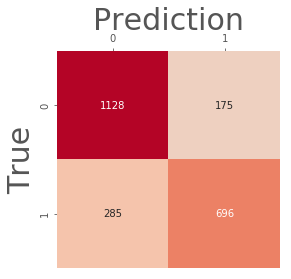

In [287]:
plt.figure(figsize = (4,4))
class_label = [0,1]
fig = sns.heatmap(confusion_matrix(y_valid,baseline_prediction),cmap= "coolwarm",annot=True,vmin=0,cbar = False,
            center = True,xticklabels=class_label,yticklabels=class_label, fmt='d' )
fig.set_xlabel("Prediction",fontsize=30)
fig.xaxis.set_label_position('top')
fig.set_ylabel("True",fontsize=30)
fig.xaxis.tick_top()

## Logistic regression

In [326]:
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

LogisticRegression()

In [328]:
linear_model_reg_prediction = log_reg_model.predict(X_valid)
linear_model_reg_accuracy = accuracy_score(y_valid,linear_model_reg_prediction)
print("training accuracy Score    : ",log_reg_model.score(X_train,y_train))
print("Validdation accuracy Score : ",linear_model_reg_accuracy )

training accuracy Score    :  0.9525239256896229
Validdation accuracy Score :  0.7937828371278459


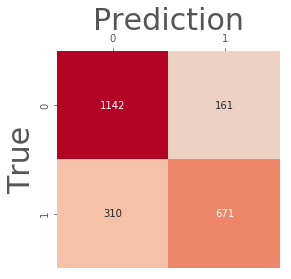

In [329]:
plt.figure(figsize = (4,4))
class_label = [0,1]
fig = sns.heatmap(confusion_matrix(y_valid,linear_model_reg_prediction),cmap= "coolwarm",annot=True,vmin=0,cbar = False,
            center = True,xticklabels=class_label,yticklabels=class_label, fmt='d' )
fig.set_xlabel("Prediction",fontsize=30)
fig.xaxis.set_label_position('top')
fig.set_ylabel("True",fontsize=30)
fig.xaxis.tick_top()

## MLP Classifier

In [340]:
mlp_classifier = MLPClassifier()
mlp_classifier.fit(X_train, y_train)

MLPClassifier()

In [341]:
mlp_prediction = mlp_classifier.predict(X_valid)
mlp_accuracy = accuracy_score(y_valid,mlp_prediction)
print("training accuracy Score    : ",mlp_classifier.score(X_train,y_train))
print("Validdation accuracy Score : ",mlp_accuracy )

training accuracy Score    :  0.9863013698630136
Validdation accuracy Score :  0.7324868651488616


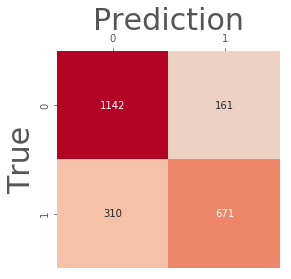

In [342]:
plt.figure(figsize = (4,4))
class_label = [0,1]
fig = sns.heatmap(confusion_matrix(y_valid,linear_model_reg_prediction),cmap= "coolwarm",annot=True,vmin=0,cbar = False,
            center = True,xticklabels=class_label,yticklabels=class_label, fmt='d' )
fig.set_xlabel("Prediction",fontsize=30)
fig.xaxis.set_label_position('top')
fig.set_ylabel("True",fontsize=30)
fig.xaxis.tick_top()

# Linear Model (SGD Classifier)

In [288]:
from sklearn.linear_model import SGDClassifier
linear_model_sgd = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)
linear_model_sgd.fit(X_train, y_train)

SGDClassifier(random_state=0)

In [289]:
linear_model_sgd_prediction = linear_model_sgd.predict(X_valid)
linear_model_sgd_accuracy = accuracy_score(y_valid,linear_model_sgd_prediction)
print("training accuracy Score    : ",linear_model_sgd.score(X_train,y_train))
print("Validdation accuracy Score : ",linear_model_sgd_accuracy )

training accuracy Score    :  0.9793582285607055
Validdation accuracy Score :  0.7697022767075307


In [290]:
md("### Our sgd model validation accuracy is {}% (heavily overfitting)".format(round(linear_model_sgd_accuracy,2)))

### Our sgd model validation accuracy is 0.77% (heavily overfitting)

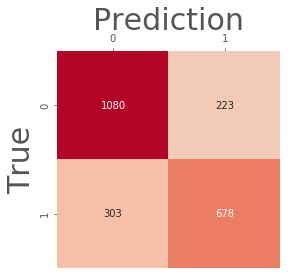

In [291]:
plt.figure(figsize = (4,4))
class_label = [0,1]
fig = sns.heatmap(confusion_matrix(y_valid,linear_model_sgd_prediction),cmap= "coolwarm",annot=True,vmin=0,cbar = False,
            center = True,xticklabels=class_label,yticklabels=class_label, fmt='d' )
fig.set_xlabel("Prediction",fontsize=30)
fig.xaxis.set_label_position('top')
fig.set_ylabel("True",fontsize=30)
fig.xaxis.tick_top()

### Parameter Tuning of SGDClassifier

In [292]:
from sklearn.model_selection import GridSearchCV

params = {
     'max_iter': (100,500,1000),
     'alpha': (1e-1,1e-2,1e-4),
      'learning_rate': ('optimal','invscaling'),
    'eta0' : (0.1,0.05),
                     
}

gridcv = GridSearchCV(linear_model_sgd,param_grid = params, cv = 5)

gridcv.fit(X_train,y_train)
print("best parameter : ")
for param_name in sorted(params.keys()):
    print("      %s: %r" % (param_name, gridcv.best_params_[param_name]))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


best parameter : 
      alpha: 0.0001
      eta0: 0.1
      learning_rate: 'invscaling'
      max_iter: 100


In [293]:
linear_model_sgd_prediction = gridcv.predict(X_valid)
linear_model_sgd_accuracy = accuracy_score(y_valid,linear_model_sgd_prediction)
print("Tune training accuracy Score    : ",gridcv.score(X_train,y_train))
print("Tune Validation accuracy Score : ",linear_model_sgd_accuracy )

Tune training accuracy Score    :  0.8438731469318822
Tune Validation accuracy Score :  0.792031523642732


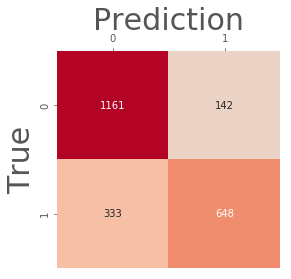

In [294]:
plt.figure(figsize = (4,4))
class_label = [0,1]
fig = sns.heatmap(confusion_matrix(y_valid,linear_model_sgd_prediction),cmap= "coolwarm",annot=True,vmin=0,cbar = False,
            center = True,xticklabels=class_label,yticklabels=class_label, fmt='d' )
fig.set_xlabel("Prediction",fontsize=30)
fig.xaxis.set_label_position('top')
fig.set_ylabel("True",fontsize=30)
fig.xaxis.tick_top()

### Classification Report of tune sgd model

In [295]:
print(classification_report(y_valid,linear_model_sgd_prediction))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1303
           1       0.82      0.66      0.73       981

    accuracy                           0.79      2284
   macro avg       0.80      0.78      0.78      2284
weighted avg       0.80      0.79      0.79      2284



In [296]:
md("### Our tune sgd model validation accuracy is {}% (less overfitting)".format(round(linear_model_sgd_accuracy,2)))

### Our tune sgd model validation accuracy is 0.79% (less overfitting)

## LSTM Model

### Preprocessing for LSTM Model

In [297]:
CRAWL_EMBEDDING_PATH = 'crawl-300d-2M.pkl'
GLOVE_EMBEDDING_PATH = 'glove.840B.300d.pkl'

In [298]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


def load_embeddings(path):
    with open(path,'rb') as f:
        emb_arr = pickle.load(f)
    return emb_arr

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

In [299]:
e = load_embeddings(GLOVE_EMBEDDING_PATH)

In [300]:
## replace unknown word with known

def replace_unknown_with_known_lstm(sent):
    to_replace = {}
    words = sent.split()
    for word in words:
        if word not in e:
            valid = True
            split_words = wordninja.split(word)
            for w in split_words:
                if w not in e:
                    valid = False
            if valid:
                new_word = ' '.join(split_words)
                to_replace[word] = new_word
    for word in to_replace:
        sent = sent.replace(word, to_replace[word])
    return sent

In [269]:
def preprocessing_lstm(df):
    df['Char_length']       = df['text'].apply(len)
    df['text']              = df.text.apply(remove_urls)
    df['text']              = df['text'].apply(emoji_to_text)
    df['text']              = df.text.apply(remove_hashtags)
    df['text']              = df.text.apply(remove_username)
    df['text']              = df.text.apply(remove_number)
    df['text']              = df.text.apply(remove_punctuations)
    df['text']              = df.text.apply(remove_symbols)
    df['text']              = df.text.apply(make_lower)
    df['text']              = df.text.apply(replace_unknown_with_known_lstm)
    return df

In [301]:
lstm_train = train.copy()
lstm_valid = valid.copy()
lstm_test = test.copy()


In [302]:
%%time

lstm_train = preprocessing_lstm(lstm_train)
lstm_valid = preprocessing_lstm(lstm_valid)
lstm_test = preprocessing_lstm(lstm_test)

CPU times: user 6.17 s, sys: 73.7 ms, total: 6.24 s
Wall time: 6.9 s


In [303]:
TEXT_COLUMN = 'text'
TARGET_COLUMN = 'target'
CHARS_TO_REMOVE = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—'

In [304]:
x_train = lstm_train[TEXT_COLUMN].astype(str)
y_train = lstm_train[TARGET_COLUMN].values

x_valid = lstm_valid[TEXT_COLUMN].astype(str)
y_valid = lstm_valid[TARGET_COLUMN].values

x_test = lstm_test[TEXT_COLUMN].astype(str)
y_test = lstm_test[TARGET_COLUMN].values

In [310]:
tokenizer = text.Tokenizer(filters=CHARS_TO_REMOVE, lower=False)
tokenizer.fit_on_texts(list(x_train) + list(x_valid) + list(x_test))

In [311]:
crawl_matrix, unknown_words_crawl = build_matrix(tokenizer.word_index, CRAWL_EMBEDDING_PATH)
print('n unknown words (crawl): ', len(unknown_words_crawl))

n unknown words (crawl):  409


In [312]:
%%time

glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print('n unknown words (glove): ', len(unknown_words_glove))

n unknown words (glove):  172
CPU times: user 8.22 s, sys: 2.52 s, total: 10.7 s
Wall time: 13.8 s


In [313]:
embedding_matrix = np.concatenate([crawl_matrix, glove_matrix], axis=-1)
embedding_matrix.shape

(16424, 600)

In [314]:
MAX_LEN = 300
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS

In [315]:
x_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)

x_valid = tokenizer.texts_to_sequences(x_valid)
x_valid = sequence.pad_sequences(x_valid, maxlen=MAX_LEN)

x_test = tokenizer.texts_to_sequences(x_test)
x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)

In [316]:
def build_model(embedding_matrix):
    words = Input(shape=(None,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(x)
    x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(x)

    hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    result = Dense(1, activation='sigmoid')(hidden)
    
    model = Model(inputs=words, outputs=result)
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model

In [317]:
NUM_MODELS = 1
BATCH_SIZE = 512
EPOCHS = 5

In [318]:
x_train.shape

(5329, 300)

In [320]:
x_valid.shape

(2284, 300)

In [319]:
x_test.shape

(3263, 300)

In [321]:
checkpoint_predictions = []
weights = []

for model_idx in range(NUM_MODELS):
    model = build_model(embedding_matrix)
    print(model)
    for global_epoch in range(EPOCHS):
        model.fit(
            x_train,y_train,
            batch_size=BATCH_SIZE,
            epochs=1,
            verbose=2
        )
        checkpoint_predictions.append(model.predict(x_valid, batch_size=BATCH_SIZE))
        weights.append(2 ** global_epoch)

11/11 - 115s - loss: 0.5504
11/11 - 97s - loss: 0.4328
11/11 - 94s - loss: 0.4071
11/11 - 97s - loss: 0.3916
11/11 - 97s - loss: 0.3778


In [322]:
predictions = np.average(checkpoint_predictions, weights=weights, axis=0)

In [333]:
predictions = (predictions > 0.5).astype(int)

In [336]:
lstm_validation_accuracy = accuracy_score(y_valid, predictions)

In [337]:
lstm_validation_accuracy

0.8231173380035026